In [1]:

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import *
from tqdm.auto import tqdm
sns.set_context('notebook')
plt.rcParams['font.family'] = ['Arial Unicode MS']

# preprocess and load data
filepath = 'train_data.pkl'
if not os.path.exists(filepath):
    general_process(output_filepath=filepath)
    
    
with open(filepath, 'rb') as fin:
    df = pickle.load(fin)
df.head(1)

# normalize all waveforms to the range [-1, 1] for better classification
df['flux_density'] = df['flux_density'].apply(
    lambda x: 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1)

In [2]:
df.iloc[5242].values[-1][0]

-0.8445677992948601

In [3]:
assert len(df[df['flux_density'].apply(lambda x: np.isnan(x).any()) == True]) == 0

,type_material,temp,freq,core_loss,type_waveform,flux_density


In [102]:
df.type_material.unique()

array(['2'], dtype=object)

# 问题一： 励磁波形分类

输入一个长度为1024的序列，输出一个类别（正弦波0、三角波1、梯形波2）

In [4]:
df[df['type_waveform'] == '梯形波'].head(1)

,type_material,temp,freq,core_loss,type_waveform,flux_density
2370,1,25,50060,12568.70593,梯形波,"[-0.533595069356785, -0.5221503770225163, -0.5..."


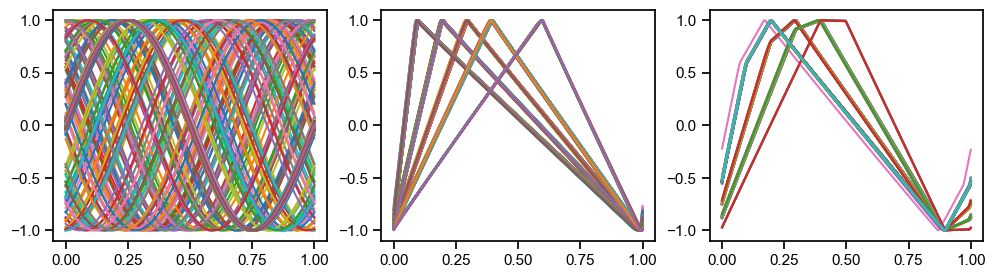

In [5]:
# iterate over the range with a step of 10, ensuring the index is within bounds
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
xs = np.linspace(0, 1, 1024)
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    for i in range(1, min(10000, len(df[df['type_waveform'] == type_waveform])), 10):
        ax.plot(xs, df[df['type_waveform'] == type_waveform]['flux_density'].iloc[i])
plt.savefig('figures/waveform.png', dpi=500, bbox_inches='tight')

## 尝试一：傅立叶变换、时频谱图

/Users/durui/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


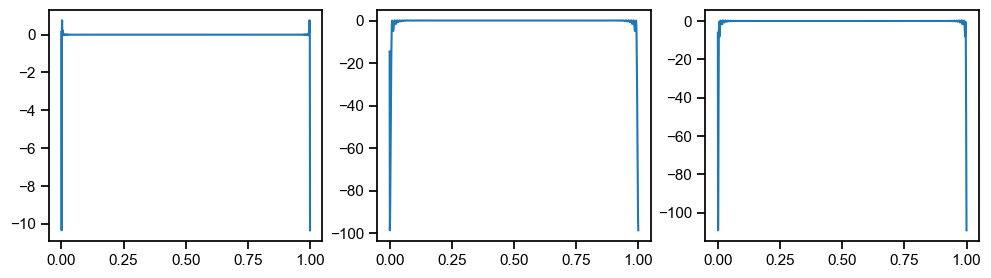

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    ax.plot(xs, np.fft.fft(df[df['type_waveform'] == type_waveform]['flux_density'].iloc[1]))

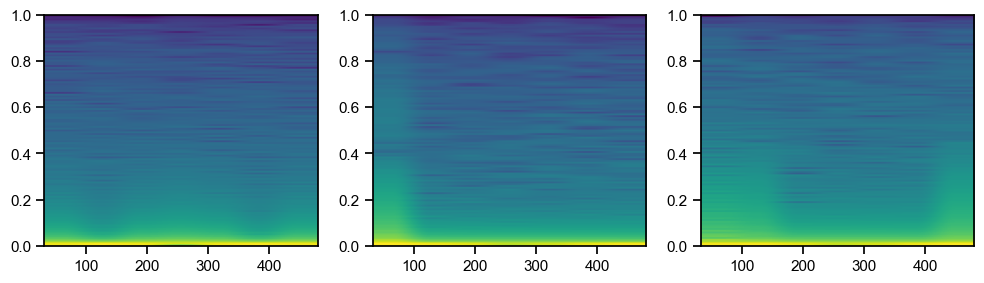

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    ax.specgram(df[df['type_waveform'] == type_waveform]['flux_density'].iloc[1])

## 尝试二：斜率变化、拐点情况（特征工程）

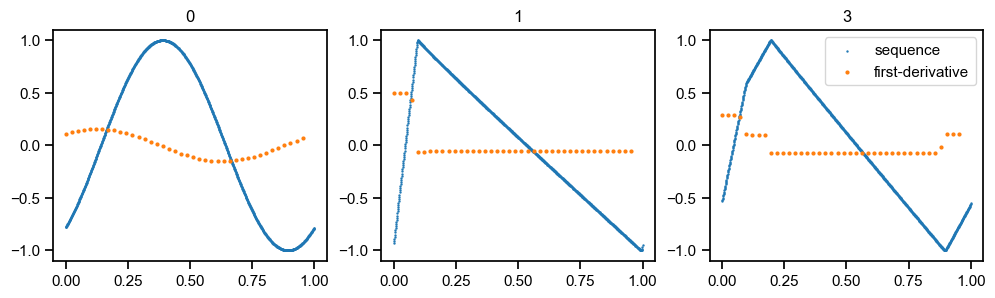

In [11]:
def break_counter(sequence, step=25, eps=0.05, verbose=False):
    """ count the number of the "change" 
    of the first_derivative is bigger than eps """
    first_derivative = np.diff(sequence[::step])
    # second_derivative = np.diff(first_derivative)
    pivots = []
    for j in range(len(first_derivative) - 1):
        if np.abs(first_derivative[j+1] - first_derivative[j]) > eps:
            if not pivots or j - pivots[-1] > 2:
                pivots.append(j)
    if verbose:
        print(pivots)
    return len(pivots)


fig, axes = plt.subplots(1, 3, figsize=(12, 3))
step = 25
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    sequence = df[df['type_waveform'] == type_waveform].sample(1)['flux_density'].values[0]
    first_derivative = np.diff(sequence[::step])
    ax.scatter(xs, sequence, label='sequence', s=0.5)
    ax.scatter(xs[::step][:-1], first_derivative, label='first-derivative', s=4)
    # count the number of the "change" of the first_derivative is bigger than eps
    ax.set_title(f'{break_counter(sequence, step=step, eps=0.075)}')
plt.legend()
plt.show()

In [12]:
df.iloc[8603]

type_material                                                    3
temp                                                            25
freq                                                         79500
core_loss                                               489739.917
type_waveform                                                  梯形波
flux_density     [-0.8825725868071932, -0.8765264220835679, -0....
Name: 8603, dtype: object

In [14]:
flag = False

for _ in tqdm(range(10_000)):
    sstep, eeps = 25, 0.05
    sequence = df[df['type_waveform'] == '正弦波'].sample(1)['flux_density'].values[0]
    assert break_counter(sequence, step=sstep, eps=eeps) == 0

    record = df[df['type_waveform'] == '三角波'].sample(1)
    sequence = record.iloc[0, -1]
    break_count = break_counter(sequence, step=sstep, eps=eeps)
    if break_count not in [1, 2]:
        flag = True
        break

    record = df[df['type_waveform'] == '梯形波'].sample(1)
    sequence = record.iloc[0, -1]
    break_count = break_counter(sequence, step=sstep, eps=eeps)
    if break_count not in [3, 4]:
        flag = True
        break

if flag:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    print(break_count, record)
    ax.scatter(xs, sequence, s=0.5)
    ax.scatter(xs[::step][:-1], first_derivative, s=4)
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

## 测试

特别把附件二中样本序号为：1, 5, 15, 25, 35, 45, 55, 65, 75, 80 的分类结果，以表格形式呈现在论文正文中。

In [15]:
test_df = pd.read_excel('dataset/附件二（测试集）.xlsx')
test_df.rename(columns={'0（磁通密度B，T）': 0}, inplace=True)
test_df['flux_density'] = test_df.iloc[:, 4:].apply(
    lambda r: r.values, axis=1)
test_df.drop(columns=[i for i in range(1024)], inplace=True)

# N.B. normalize all waveforms to the range [-1, 1] 
# in accordance with the training data
test_df['flux_density'] = test_df['flux_density'].apply(
    lambda x: 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1)
test_df.head()

,序号,温度，oC,频率，Hz,磁芯材料,flux_density
0,1,25,56180,材料1,"[-0.9429278162336249, -0.9229889379590293, -0...."
1,2,25,125890,材料1,"[-0.9312517683534196, -0.9112330452007968, -0...."
2,3,25,224180,材料1,"[-0.9028416913766483, -0.8820358289679819, -0...."
3,4,25,282480,材料1,"[-0.8595153353572332, -0.8393062754266409, -0...."
4,5,50,199170,材料1,"[-0.9211476973254586, -0.9006206833456822, -0...."


In [16]:
type2name = {0: '正弦波', 1: '三角波', 2: '梯形波'}
counter2type = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2, }

test_df['励磁波形'] = test_df.apply(lambda x: counter2type[break_counter(x['flux_density'], step=25, eps=0.05)], axis=1)
test_df.head()
test_df.to_excel('test_df.xlsx', index=False)

/var/folders/hq/mrh1wvlx1r9crbtgy7q4hfbc0000gn/T/ipykernel_45682/215761384.py:6: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.2' currently installed).
  test_df.to_excel('test_df.xlsx', index=False)


In [18]:
test_df

,序号,温度，oC,频率，Hz,磁芯材料,flux_density,励磁波形
0,1,25,56180,材料1,"[-0.9429278162336249, -0.9229889379590293, -0....",1
1,2,25,125890,材料1,"[-0.9312517683534196, -0.9112330452007968, -0....",1
2,3,25,224180,材料1,"[-0.9028416913766483, -0.8820358289679819, -0....",1
3,4,25,282480,材料1,"[-0.8595153353572332, -0.8393062754266409, -0....",1
4,5,50,199170,材料1,"[-0.9211476973254586, -0.9006206833456822, -0....",1
...,...,...,...,...,...,...
75,76,25,89080,材料4,"[-0.013734466683050561, -0.007562068208353145,...",0
76,77,25,251170,材料4,"[0.004685617520659546, 0.010871439782496495, 0...",0
77,78,50,79470,材料4,"[0.012765596666491907, 0.01893978327588175, 0....",0
78,79,50,251170,材料4,"[-0.03090998333697459, -0.024745700178830488, ...",0


In [19]:
sequence = test_df.iloc[-1]['flux_density']
len(sequence)

1024

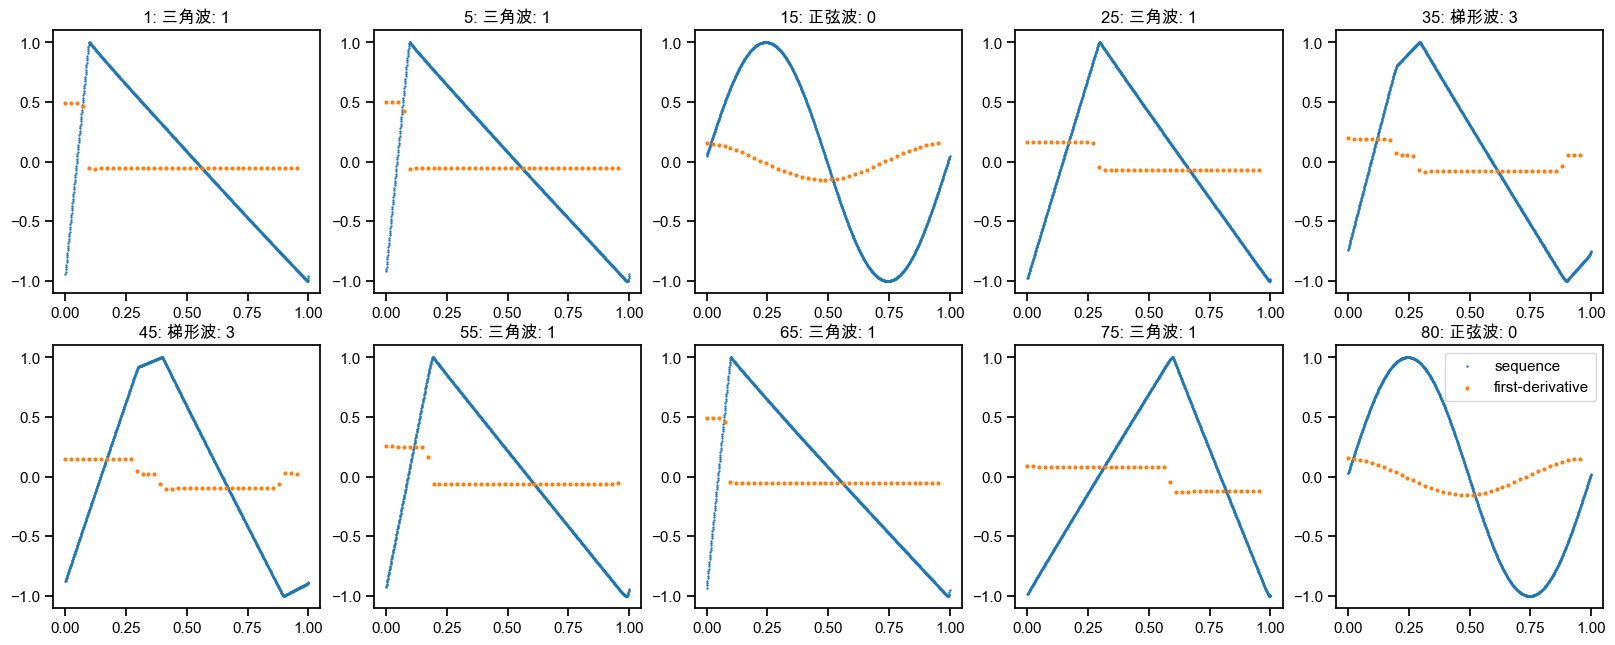

In [21]:
xs = np.linspace(0, 1, 1024)
fig, axes = plt.subplots(2, 5, figsize=(20, 7.5))
for i, ax in zip([1, 5, 15, 25, 35, 45, 55, 65, 75, 80], axes.flatten()):
    sequence = test_df.iloc[i-1]['flux_density']
    sequence = np.array([float(x) for x in sequence])  # convert each element to float and then to numpy array
    first_derivative = np.diff(sequence[::25])
    ax.scatter(xs, sequence, label='sequence', s=0.5)
    ax.scatter(xs[::step][:-1], first_derivative, label='first-derivative', s=4)
    ax.set_title(f'{i}: {type2name[test_df.iloc[i-1]["励磁波形"]]}: {break_counter(sequence)}')
plt.legend()
plt.savefig('figures/p1.pdf', bbox_inches='tight')

## 后记：参数设定


In [92]:
set_step = [5, 8, 16, 25, 40, 64, 128]
set_eps = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]